<a href="https://colab.research.google.com/github/Anindyait/Big-Data-Project/blob/main/Spatio_Temporal_Modeling_on_COVID_19_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**📒 Spatio-Temporal Analysis on COVID-19 Data**

**Big Data, DAL-588 | Phase - 2**

- Akriti Gulati - 24565002
- Anindya Biswas - 24565003
- Arpit Kumar Chaudhary - 24566006
- Priya Gupta - 24565013


#Installs

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 103.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# Importing Dataset

In [ ]:
df = pd.read_csv('covid_19_data.csv')
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


Cleaning

In [ ]:
df = df.copy()

# Replace negative or NaN values with 0
for col in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # force non-numeric to NaN
    df[col] = df[col].clip(lower=0)                    # remove negatives
    df[col] = df[col].fillna(0)                        # replace NaNs with 0
    df[col] = np.log1p(df[col])                        # apply log1p safely


Grid Size for the CNN

In [ ]:
# Define grid size
lat_bins = np.linspace(-90, 90, 61)   # 60 bins
lon_bins = np.linspace(-180, 180, 121)  # 120 bins


def get_bin_indices(lat, lon):
    lat_idx = np.digitize(lat, lat_bins) - 1
    lon_idx = np.digitize(lon, lon_bins) - 1
    return lat_idx, lon_idx


Normalization

In [ ]:
# Normalized
df['Confirmed'] = np.log1p(df['Confirmed'])
df['Deaths'] = np.log1p(df['Deaths'])
df['Recovered'] = np.log1p(df['Recovered'])
df['Active'] = np.log1p(df['Active'])

Pre-Processing

In [ ]:
from tqdm import tqdm

# Preprocess
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date'])

# Unique dates
dates = df['Date'].unique()
grid_frames = []

for date in tqdm(dates):
    day_df = df[df['Date'] == date]
    grid = np.zeros((60, 120, 4))

    for _, row in day_df.iterrows():
        lat, lon = row['Lat'], row['Long']
        lat_idx, lon_idx = get_bin_indices(lat, lon)

        if 0 <= lat_idx < 180 and 0 <= lon_idx < 360:
            grid[lat_idx, lon_idx, 0] += row['Confirmed']
            grid[lat_idx, lon_idx, 1] += row['Deaths']
            grid[lat_idx, lon_idx, 2] += row['Recovered']
            grid[lat_idx, lon_idx, 3] += row['Active']

    grid_frames.append(grid)


100%|██████████| 188/188 [00:04<00:00, 44.29it/s]


# CNN-LSTM Model for Confirmed Cases

In [ ]:
X_seq = []
Y_seq = []
seq_len = 7  # past 7 days to predict the next

for i in range(len(grid_frames) - seq_len):
    X = np.stack(grid_frames[i:i+seq_len])        # Shape: [7, 180, 360, 4]
    Y = grid_frames[i+seq_len][:, :, 0]           # Predict next day's confirmed
    X_seq.append(X)
    Y_seq.append(Y)

X_seq = np.array(X_seq)  # [samples, time, H, W, C]
Y_seq = np.array(Y_seq)  # [samples, H, W]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torch
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self, input_shape=(4, 60, 120)):  # (C, H, W)
        super(CNNLSTM, self).__init__()

        # CNN to extract spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Downsample H/2 x W/2
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   # Downsample H/4 x W/4
        )

        # Dynamically compute CNN output size
        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)  # Shape: (C, H, W)
            cnn_out = self.cnn(dummy)
            self.cnn_out_dim = cnn_out.reshape(1, -1).shape[1]

        # LSTM over time dimension
        self.lstm = nn.LSTM(input_size=self.cnn_out_dim, hidden_size=128, batch_first=True)

        # Output layer to predict next grid (1 channel)
        self.output_height = input_shape[1]
        self.output_width = input_shape[2]
        self.fc = nn.Linear(128, self.output_height * self.output_width)

    def forward(self, x):
        """
        x: Tensor of shape [B, T, H, W, C]
        """
        B, T, H, W, C = x.shape
        x = x.permute(0, 1, 4, 2, 3)  # [B, T, C, H, W]

        cnn_out_seq = []

        for t in range(T):
            cnn_out = self.cnn(x[:, t])         # [B, C', H', W']
            cnn_out = cnn_out.reshape(B, -1)     # Flatten to [B, D]
            cnn_out_seq.append(cnn_out)

        cnn_out_seq = torch.stack(cnn_out_seq, dim=1)  # [B, T, D]

        lstm_out, _ = self.lstm(cnn_out_seq)           # [B, T, 128]
        final_output = lstm_out[:, -1]                 # [B, 128]

        prediction = self.fc(final_output)             # [B, H*W]
        return prediction.view(B, self.output_height, self.output_width)  # [B, H, W]


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch

# Convert to arrays if not already
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)


dates_seq = dates[seq_len:]  # skip first 7 days to match sequences


# First split: train + temp (val+test)
X_train, X_temp, Y_train, Y_temp, dates_train, dates_temp = train_test_split(
    X_seq, Y_seq, dates_seq, test_size=0.3, shuffle=False)


# Second split: val + test
X_val, X_test, Y_val, Y_test, dates_val, dates_test = train_test_split(
    X_temp, Y_temp, dates_temp, test_size=0.5, shuffle=False)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

dates_train, dates_temp = train_test_split(dates, test_size=0.3, shuffle=False)
dates_val, dates_test = train_test_split(dates_temp, test_size=0.5, shuffle=False)


# Create datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model
model = CNNLSTM(input_shape=(4, 60, 120))  # Adjust this to match your H, W
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(20):
    model.train()
    total_train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader:
            val_output = model(X_val_batch)
            val_loss = criterion(val_output, Y_val_batch)
            total_val_loss += val_loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f}")


Epoch 1 | Train Loss: 1.7709 | Val Loss: 0.7302
Epoch 2 | Train Loss: 1.6724 | Val Loss: 0.7008
Epoch 3 | Train Loss: 1.5599 | Val Loss: 0.6293
Epoch 4 | Train Loss: 1.3060 | Val Loss: 0.4645
Epoch 5 | Train Loss: 0.8864 | Val Loss: 0.2987
Epoch 6 | Train Loss: 0.5900 | Val Loss: 0.1961
Epoch 7 | Train Loss: 0.4156 | Val Loss: 0.1386
Epoch 8 | Train Loss: 0.3177 | Val Loss: 0.1038
Epoch 9 | Train Loss: 0.2591 | Val Loss: 0.0823
Epoch 10 | Train Loss: 0.2239 | Val Loss: 0.0676
Epoch 11 | Train Loss: 0.1995 | Val Loss: 0.0564
Epoch 12 | Train Loss: 0.1825 | Val Loss: 0.0487
Epoch 13 | Train Loss: 0.1697 | Val Loss: 0.0428
Epoch 14 | Train Loss: 0.1585 | Val Loss: 0.0391
Epoch 15 | Train Loss: 0.1513 | Val Loss: 0.0358
Epoch 16 | Train Loss: 0.1445 | Val Loss: 0.0328
Epoch 17 | Train Loss: 0.1408 | Val Loss: 0.0299
Epoch 18 | Train Loss: 0.1351 | Val Loss: 0.0288
Epoch 19 | Train Loss: 0.1293 | Val Loss: 0.0266
Epoch 20 | Train Loss: 0.1254 | Val Loss: 0.0250


In [ ]:
idx = 0  # Index of the sample you want to check

model.eval()
with torch.no_grad():
    X_input = X_val_tensor[idx:idx+1].to(device)  # Shape: [1, T, H, W, C]
    pred = model(X_input).cpu().numpy()[0]        # Shape: [H, W]
    actual = Y_val_tensor[idx].cpu().numpy()      # Shape: [H, W]


In [ ]:
model.eval()
pred_seq = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch).cpu().numpy()  # shape: [B, H, W]
        pred_seq.extend(output)  # list of [H, W] arrays

pred_seq = np.array(pred_seq)  # shape: [N_val, H, W]


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_grid_on_map(pred_grid, title="Predicted Cases (log1p)", vmin=None, vmax=None):
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the image (pred_grid must be [H, W] with H=lat, W=lon)
    img = ax.imshow(
        pred_grid, origin='lower',
        extent=[-180, 180, -90, 90],  # lon_min, lon_max, lat_min, lat_max
        cmap='hot', vmin=vmin, vmax=vmax, alpha=0.8
    )

    ax.coastlines()
    plt.title(title)
    plt.colorbar(img, orientation='vertical', label='log(1 + cases)')
    plt.show()


## Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten predicted and actual arrays
pred_flat = pred.flatten()
actual_flat = actual.flatten()

# Compute metrics
mse = mean_squared_error(actual_flat, pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_flat, pred_flat)
r2 = r2_score(actual_flat, pred_flat)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


MSE:  0.0053
RMSE: 0.0731
MAE:  0.0182
R²:   0.9694


## Vizualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_pred_vs_actual(model, X_val_tensor, Y_val, dates_val, device, idx=0, channel=0):


    model.eval()
    with torch.no_grad():
        # Ensure input tensor is on the same device as the model
        X_input = X_val_tensor[idx:idx+1].to(device).float()

        # Make sure model is on the same device and in float precision
        model = model.to(device).float()

        pred = model(X_input).cpu().numpy()[0]  # output shape: [H, W]

    actual = Y_val[idx]  # actual shape: [H, W], numpy array on CPU


    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(pred, cmap='hot', origin="lower")
    plt.title(f'Predicted Confirmed Cases\nDate: {dates_val[idx]}')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.imshow(actual, cmap='hot', origin="lower")
    plt.title(f'Actual Confirmed Cases\nDate: {dates_val[idx]}')
    plt.colorbar()

    plt.show()


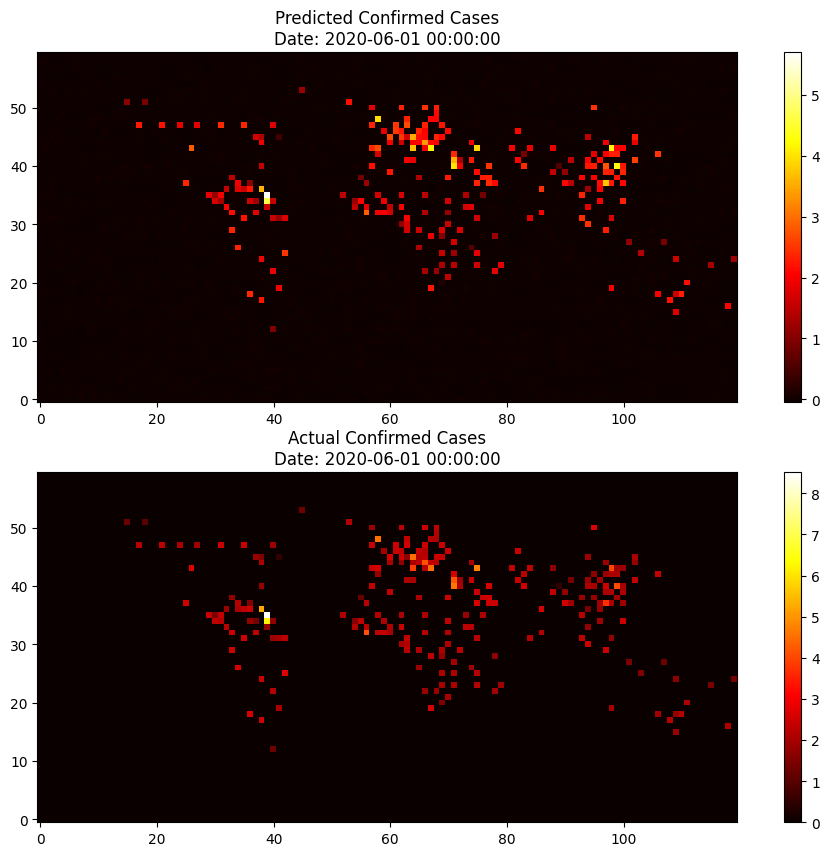

In [ ]:
plot_pred_vs_actual(model, X_test_tensor, Y_test, dates_val, device, idx=0)

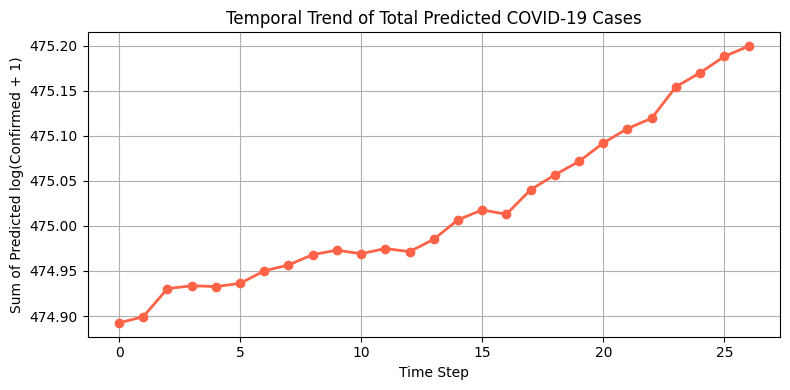

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pred_seq: shape [T, H, W]
# Aggregate over space: sum all grid cells for each time step
pred_total = pred_seq.sum(axis=(1, 2))  # shape: [T]

# Plot the aggregated values over time
plt.figure(figsize=(8, 4))
plt.plot(pred_total, marker='o', color='tomato', linewidth=2)
plt.title('Temporal Trend of Total Predicted COVID-19 Cases')
plt.xlabel('Time Step')
plt.ylabel('Sum of Predicted log(Confirmed + 1)')
plt.grid(True)
plt.tight_layout()
plt.show()


# CNN-LSTM Model for Death Cases

In [ ]:
X_seq = []
Y_seq = []
seq_len = 7  # past 7 days to predict the next

for i in range(len(grid_frames) - seq_len):
    X = np.stack(grid_frames[i:i+seq_len])        # Shape: [7, 180, 360, 4]
    Y = grid_frames[i+seq_len][:, :, 1]           # Predict next day's deaths
    X_seq.append(X)
    Y_seq.append(Y)

X_seq = np.array(X_seq)  # [samples, time, H, W, C]
Y_seq = np.array(Y_seq)  # [samples, H, W]


In [ ]:
# Convert to arrays if not already
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)


dates_seq = dates[seq_len:]  # skip first 7 days to match sequences


# First split: train + temp (val+test)
X_train, X_temp, Y_train, Y_temp, dates_train, dates_temp = train_test_split(
    X_seq, Y_seq, dates_seq, test_size=0.3, shuffle=False)


# Second split: val + test
X_val, X_test, Y_val, Y_test, dates_val, dates_test = train_test_split(
    X_temp, Y_temp, dates_temp, test_size=0.5, shuffle=False)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

dates_train, dates_temp = train_test_split(dates, test_size=0.3, shuffle=False)
dates_val, dates_test = train_test_split(dates_temp, test_size=0.5, shuffle=False)


# Create datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model
model = CNNLSTM(input_shape=(4, 60, 120))  # Adjust this to match your H, W
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for epoch in range(20):
    model.train()
    total_train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, Y_val_batch in val_loader:
            val_output = model(X_val_batch)
            val_loss = criterion(val_output, Y_val_batch)
            total_val_loss += val_loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f}")


Epoch 1 | Train Loss: 0.7030 | Val Loss: 0.3475
Epoch 2 | Train Loss: 0.6309 | Val Loss: 0.3389
Epoch 3 | Train Loss: 0.6083 | Val Loss: 0.3239
Epoch 4 | Train Loss: 0.5626 | Val Loss: 0.2955
Epoch 5 | Train Loss: 0.4897 | Val Loss: 0.2345
Epoch 6 | Train Loss: 0.3466 | Val Loss: 0.1407
Epoch 7 | Train Loss: 0.2105 | Val Loss: 0.0826
Epoch 8 | Train Loss: 0.1396 | Val Loss: 0.0558
Epoch 9 | Train Loss: 0.1036 | Val Loss: 0.0403
Epoch 10 | Train Loss: 0.0822 | Val Loss: 0.0328
Epoch 11 | Train Loss: 0.0712 | Val Loss: 0.0277
Epoch 12 | Train Loss: 0.0631 | Val Loss: 0.0246
Epoch 13 | Train Loss: 0.0577 | Val Loss: 0.0218
Epoch 14 | Train Loss: 0.0537 | Val Loss: 0.0201
Epoch 15 | Train Loss: 0.0505 | Val Loss: 0.0190
Epoch 16 | Train Loss: 0.0477 | Val Loss: 0.0181
Epoch 17 | Train Loss: 0.0455 | Val Loss: 0.0167
Epoch 18 | Train Loss: 0.0437 | Val Loss: 0.0158
Epoch 19 | Train Loss: 0.0412 | Val Loss: 0.0156
Epoch 20 | Train Loss: 0.0392 | Val Loss: 0.0149


In [ ]:
model = model.to(device)        # move model to GPU or CPU
X_input = X_input.to(device)    # move input tensor to same device
model.eval()
with torch.no_grad():
    pred = model(X_input).cpu().numpy()[0]

In [ ]:
idx = 0  # Index of the sample you want to check

model.eval()
with torch.no_grad():
    X_input = X_val_tensor[idx:idx+1].to(device)  # Shape: [1, T, H, W, C]
    pred = model(X_input).cpu().numpy()[0]        # Shape: [H, W]
    actual = Y_val_tensor[idx].cpu().numpy()      # Shape: [H, W]


In [ ]:
model.eval()
pred_seq = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch).cpu().numpy()  # shape: [B, H, W]
        pred_seq.extend(output)  # list of [H, W] arrays

pred_seq = np.array(pred_seq)  # shape: [N_val, H, W]


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_grid_on_map(pred_grid, title="Predicted Cases (log1p)", vmin=None, vmax=None):
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the image (pred_grid must be [H, W] with H=lat, W=lon)
    img = ax.imshow(
        pred_grid, origin='lower',
        extent=[-180, 180, -90, 90],  # lon_min, lon_max, lat_min, lat_max
        cmap='hot', vmin=vmin, vmax=vmax, alpha=0.8
    )

    ax.coastlines()
    plt.title(title)
    plt.colorbar(img, orientation='vertical', label='log(1 + cases)')
    plt.show()


## Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Flatten predicted and actual arrays
pred_flat = pred.flatten()
actual_flat = actual.flatten()

# Compute metrics
mse = mean_squared_error(actual_flat, pred_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_flat, pred_flat)
r2 = r2_score(actual_flat, pred_flat)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


MSE:  0.0025
RMSE: 0.0499
MAE:  0.0121
R²:   0.9685


## Vizualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_pred_vs_actual(model, X_val_tensor, Y_val, dates_val, device, idx=0, channel=0):


    model.eval()
    with torch.no_grad():
        X_input = X_val_tensor[idx:idx+1].to(device).float()

        model = model.to(device).float()

        pred = model(X_input).cpu().numpy()[0]  # output shape: [H, W]

    actual = Y_val[idx]  # actual shape: [H, W], numpy array on CPU


    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(pred, cmap='hot', origin="lower")
    plt.title(f'Predicted Deaths\nDate: {dates_val[idx]}')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.imshow(actual, cmap='hot', origin="lower")
    plt.title(f'Actual Deaths\nDate: {dates_val[idx]}')
    plt.colorbar()

    plt.show()


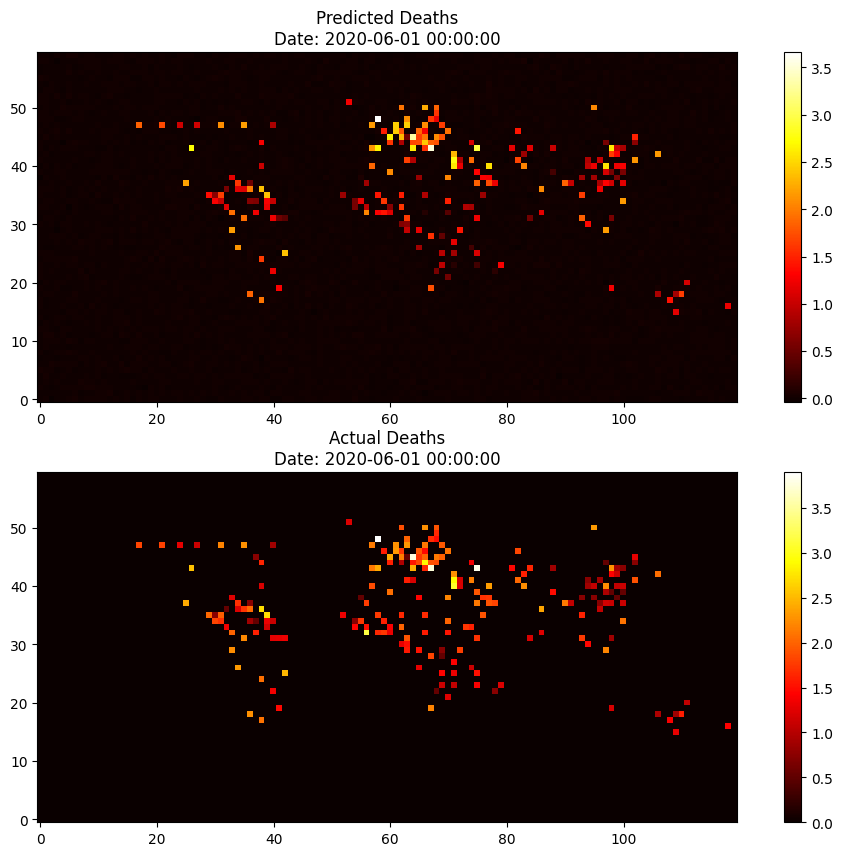

In [ ]:
plot_pred_vs_actual(model, X_test_tensor, Y_test, dates_val, device, idx=0)

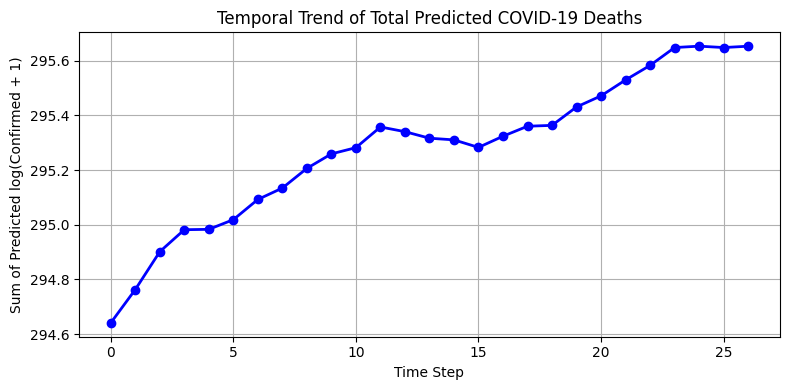

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


pred_total = pred_seq.sum(axis=(1, 2))  # shape: [T]

# Plot the aggregated values over time
plt.figure(figsize=(8, 4))
plt.plot(pred_total, marker='o', color='blue', linewidth=2)
plt.title('Temporal Trend of Total Predicted COVID-19 Deaths')
plt.xlabel('Time Step')
plt.ylabel('Sum of Predicted log(Confirmed + 1)')
plt.grid(True)
plt.tight_layout()
plt.show()
